In [ ]:
!pip install sklearn
!pip install underthesea
!pip install langdetect
!pip install wordcloud

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import sklearn
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex
import re
import string
import time
import os
import pickle

from langdetect import detect
from collections import Counter
from underthesea import word_tokenize, pos_tag, sent_tokenize

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
filepath = '/content/gdrive/MyDrive/Sentiment-Analysis/machine_learning/Data/data.csv'

In [ ]:
pd.set_option("display.max_colwidth", None)

#Đọc dữ liệu

In [ ]:
data = pd.read_csv(filepath, encoding="utf-8", delimiter=";")
data['Body_new'].head()

,Body_new
0,"Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên rất thân thiện. Tầm nhìn từ phòng nhìn ra biển rộng lớn và tôi đã cảm động mỗi lần nhìn. Đặc biệt là bình minh rất tuyệt vời. Vì vậy, tôi khuyên bạn nên chọn phòng với tầm nhìn ra đại dương."
1,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt Online được nhiều ưu đãi. Bữa sáng khá phong phú và đầy đủ dưỡng chất. Món cà ri Tôm khách sạn mời rất ngon. Sinh nhật tôi được bạn Hồng chúc mừng sinh nhật và tạo bất ngờ tại phòng.
2,"Lần này đến với Nha Trang, tôi book phòng tại khách sạn Mường Thanh Luxury. Khách sạn trên đường Trần Phú, có view rất chill và thuận lợi để tắm biển. Nhân viên quầy lễ tân niềm nở, tận tình hướng dẫn, thủ tục nhận phòng đơn giản và nhanh chóng."
3,"Hôm đi đến lúc về thì mọi thứ trong Khách sạn điều tuyết vời, Nhân viên đón tiép nhiệt tình, tiện nghi đầy đủ."
4,"Khách sạn có vị trí trung tâm và sát biển. Nhân viên vui vẻ, thân thiện, mình check-in gặp bạn tiếp tân tên Lĩnh và bạn nhận hành lý tên Hiếu hỗ trợ rất nhiệt tình ! Phòng khách sạn rộng rãi , thoáng, phòng view biển quá đẹp !"


In [ ]:
data = data[['Body_new', 'Tag']]
data.head()

,Body_new,Tag
0,"Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên rất thân thiện. Tầm nhìn từ phòng nhìn ra biển rộng lớn và tôi đã cảm động mỗi lần nhìn. Đặc biệt là bình minh rất tuyệt vời. Vì vậy, tôi khuyên bạn nên chọn phòng với tầm nhìn ra đại dương.",Positive
1,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt Online được nhiều ưu đãi. Bữa sáng khá phong phú và đầy đủ dưỡng chất. Món cà ri Tôm khách sạn mời rất ngon. Sinh nhật tôi được bạn Hồng chúc mừng sinh nhật và tạo bất ngờ tại phòng.,Positive
2,"Lần này đến với Nha Trang, tôi book phòng tại khách sạn Mường Thanh Luxury. Khách sạn trên đường Trần Phú, có view rất chill và thuận lợi để tắm biển. Nhân viên quầy lễ tân niềm nở, tận tình hướng dẫn, thủ tục nhận phòng đơn giản và nhanh chóng.",Positive
3,"Hôm đi đến lúc về thì mọi thứ trong Khách sạn điều tuyết vời, Nhân viên đón tiép nhiệt tình, tiện nghi đầy đủ.",Positive
4,"Khách sạn có vị trí trung tâm và sát biển. Nhân viên vui vẻ, thân thiện, mình check-in gặp bạn tiếp tân tên Lĩnh và bạn nhận hành lý tên Hiếu hỗ trợ rất nhiệt tình ! Phòng khách sạn rộng rãi , thoáng, phòng view biển quá đẹp !",Positive


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Body_new  1037 non-null   object
 1   Tag       1037 non-null   object
dtypes: object(2)
memory usage: 16.3+ KB


In [ ]:
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 976 entries, 0 to 1036
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Body_new  976 non-null    object
 1   Tag       976 non-null    object
dtypes: object(2)
memory usage: 22.9+ KB


#Chuẩn hóa dữ liệu

## Xử lý dữ liệu tiếng việt

In [ ]:
##LOAD EMOJICON
file = open('/content/gdrive/MyDrive/Sentiment-Analysis/files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()
#################
#LOAD TEENCODE
file = open('/content/gdrive/MyDrive/Sentiment-Analysis/files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('/content/gdrive/MyDrive/Sentiment-Analysis/files/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()
################
#LOAD wrong words
file = open('/content/gdrive/MyDrive/Sentiment-Analysis/files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('/content/gdrive/MyDrive/Sentiment-Analysis/files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

## Chuyển đổi emoji thành cảm xúc tương ứng, teencode và các từ tiếng anh, xóa các từ sai.

In [ ]:
def process_text(text, emoji_dict=emoji_dict, teen_dict=teen_dict, wrong_lst=wrong_lst, english_dict=english_dict):
    document = text.lower()
    document = document.replace("’", '')
    document = regex.sub(r'\.+', ".", document)

    new_sentence = []
    for sentence in sent_tokenize(document):
        # Loại bỏ số và dấu câu, giữ lại từ tiếng Việt
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        words = regex.findall(pattern, sentence)

        cleaned_words = []
        for word in words:
            # Chuyển đổi emoji
            if word in emoji_dict:
                cleaned_words.append(emoji_dict[word])
            # Chuyển đổi teen code
            elif word in teen_dict:
                cleaned_words.append(teen_dict[word])
            # Chuyển đổi từ tiếng Anh sang tiếng Việt
            elif word in english_dict:
                cleaned_words.append(english_dict[word])
            # Xóa từ sai chính tả
            elif word not in wrong_lst:
                cleaned_words.append(word)

        if cleaned_words:
            new_sentence.append(' '.join(cleaned_words) + '.')

    # Xóa khoảng trắng dư thừa
    document = ' '.join(new_sentence).strip()
    return document


In [ ]:
data['Body_pre'] = data['Body_new'].apply(process_text)
data.head(5)

,Body_new,Tag,Body_pre
0,"Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên rất thân thiện. Tầm nhìn từ phòng nhìn ra biển rộng lớn và tôi đã cảm động mỗi lần nhìn. Đặc biệt là bình minh rất tuyệt vời. Vì vậy, tôi khuyên bạn nên chọn phòng với tầm nhìn ra đại dương.",Positive,tôi đã ở cùng chủ nhân đêm. nhân viên rất thân thiện. tầm nhìn từ phòng nhìn biển rộng lớn và tôi đã cảm động mỗi lần nhìn. đặc biệt là bình rất tuyệt vời. vì vậy tôi khuyên bạn nên chọn phòng với tầm nhìn đại dương.
1,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt Online được nhiều ưu đãi. Bữa sáng khá phong phú và đầy đủ dưỡng chất. Món cà ri Tôm khách sạn mời rất ngon. Sinh nhật tôi được bạn Hồng chúc mừng sinh nhật và tạo bất ngờ tại phòng.,Positive,lựa chọn mường vì giá cả phù hợp. đặt trực tuyến được nhiều ưu đãi. bữa sáng khá phú và đầy đủ dưỡng chất. món cà tôm khách sạn mời rất. nhật tôi được bạn hồng chúc mừng nhật và tạo bất ngờ tại phòng.
2,"Lần này đến với Nha Trang, tôi book phòng tại khách sạn Mường Thanh Luxury. Khách sạn trên đường Trần Phú, có view rất chill và thuận lợi để tắm biển. Nhân viên quầy lễ tân niềm nở, tận tình hướng dẫn, thủ tục nhận phòng đơn giản và nhanh chóng.",Positive,lần này đến với tôi đặt chỗ phòng tại khách sạn mường sang trọng. khách sạn trên đường trần phú có phong cảnh rất rất thư giãn và dễ chịu và thuận lợi để tắm biển. nhân viên quầy lễ tân niềm nở tận tình hướng dẫn thủ tục nhận phòng đơn giản và nhanh chóng chóng.
3,"Hôm đi đến lúc về thì mọi thứ trong Khách sạn điều tuyết vời, Nhân viên đón tiép nhiệt tình, tiện nghi đầy đủ.",Positive,hôm đi đến lúc về thì mọi thứ khách sạn điều tuyết vời nhân viên đón tiép nhiệt tình tiện đầy đủ.
4,"Khách sạn có vị trí trung tâm và sát biển. Nhân viên vui vẻ, thân thiện, mình check-in gặp bạn tiếp tân tên Lĩnh và bạn nhận hành lý tên Hiếu hỗ trợ rất nhiệt tình ! Phòng khách sạn rộng rãi , thoáng, phòng view biển quá đẹp !",Positive,khách sạn có vị trí tâm và sát biển. nhân viên vui vẻ thân thiện mình kiểm tra gặp bạn tiếp tân tên lĩnh và bạn nhận hành lý tên hiếu hỗ trợ rất nhiệt tình. phòng khách sạn rộng rãi thoáng phòng phong cảnh biển quá đẹp.


In [ ]:
data.to_csv("data_1.csv", index=False, encoding="utf-8-sig")

In [ ]:
#Lọc giữ lại các dòng tiếng việt
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

In [ ]:
data['Language'] = data['Body_pre'].apply(detect_language)
data = data[data['Language'] == 'vi']

In [ ]:
data.drop('Language', axis=1, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 976 entries, 0 to 1036
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Body_new  976 non-null    object
 1   Tag       976 non-null    object
 2   Body_pre  976 non-null    object
dtypes: object(3)
memory usage: 30.5+ KB


In [ ]:
# Chuẩn hóa unicode tiếng việt
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [ ]:
data['Body_pre'] = data['Body_pre'].astype(str)
data['Body_pre_load'] = data['Body_pre'].apply(covert_unicode)
print(data.count())
data.drop('Body_pre', axis=1, inplace=True)
data.head()

Body_new         976
Tag              976
Body_pre         976
Body_pre_load    976
dtype: int64


,Body_new,Tag,Body_pre_load
0,"Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên rất thân thiện. Tầm nhìn từ phòng nhìn ra biển rộng lớn và tôi đã cảm động mỗi lần nhìn. Đặc biệt là bình minh rất tuyệt vời. Vì vậy, tôi khuyên bạn nên chọn phòng với tầm nhìn ra đại dương.",Positive,tôi đã ở cùng chủ nhân đêm. nhân viên rất thân thiện. tầm nhìn từ phòng nhìn biển rộng lớn và tôi đã cảm động mỗi lần nhìn. đặc biệt là bình rất tuyệt vời. vì vậy tôi khuyên bạn nên chọn phòng với tầm nhìn đại dương.
1,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt Online được nhiều ưu đãi. Bữa sáng khá phong phú và đầy đủ dưỡng chất. Món cà ri Tôm khách sạn mời rất ngon. Sinh nhật tôi được bạn Hồng chúc mừng sinh nhật và tạo bất ngờ tại phòng.,Positive,lựa chọn mường vì giá cả phù hợp. đặt trực tuyến được nhiều ưu đãi. bữa sáng khá phú và đầy đủ dưỡng chất. món cà tôm khách sạn mời rất. nhật tôi được bạn hồng chúc mừng nhật và tạo bất ngờ tại phòng.
2,"Lần này đến với Nha Trang, tôi book phòng tại khách sạn Mường Thanh Luxury. Khách sạn trên đường Trần Phú, có view rất chill và thuận lợi để tắm biển. Nhân viên quầy lễ tân niềm nở, tận tình hướng dẫn, thủ tục nhận phòng đơn giản và nhanh chóng.",Positive,lần này đến với tôi đặt chỗ phòng tại khách sạn mường sang trọng. khách sạn trên đường trần phú có phong cảnh rất rất thư giãn và dễ chịu và thuận lợi để tắm biển. nhân viên quầy lễ tân niềm nở tận tình hướng dẫn thủ tục nhận phòng đơn giản và nhanh chóng chóng.
3,"Hôm đi đến lúc về thì mọi thứ trong Khách sạn điều tuyết vời, Nhân viên đón tiép nhiệt tình, tiện nghi đầy đủ.",Positive,hôm đi đến lúc về thì mọi thứ khách sạn điều tuyết vời nhân viên đón tiép nhiệt tình tiện đầy đủ.
4,"Khách sạn có vị trí trung tâm và sát biển. Nhân viên vui vẻ, thân thiện, mình check-in gặp bạn tiếp tân tên Lĩnh và bạn nhận hành lý tên Hiếu hỗ trợ rất nhiệt tình ! Phòng khách sạn rộng rãi , thoáng, phòng view biển quá đẹp !",Positive,khách sạn có vị trí tâm và sát biển. nhân viên vui vẻ thân thiện mình kiểm tra gặp bạn tiếp tân tên lĩnh và bạn nhận hành lý tên hiếu hỗ trợ rất nhiệt tình. phòng khách sạn rộng rãi thoáng phòng phong cảnh biển quá đẹp.


In [ ]:
data.to_csv("data_2.csv", index=False, encoding="utf-8-sig")

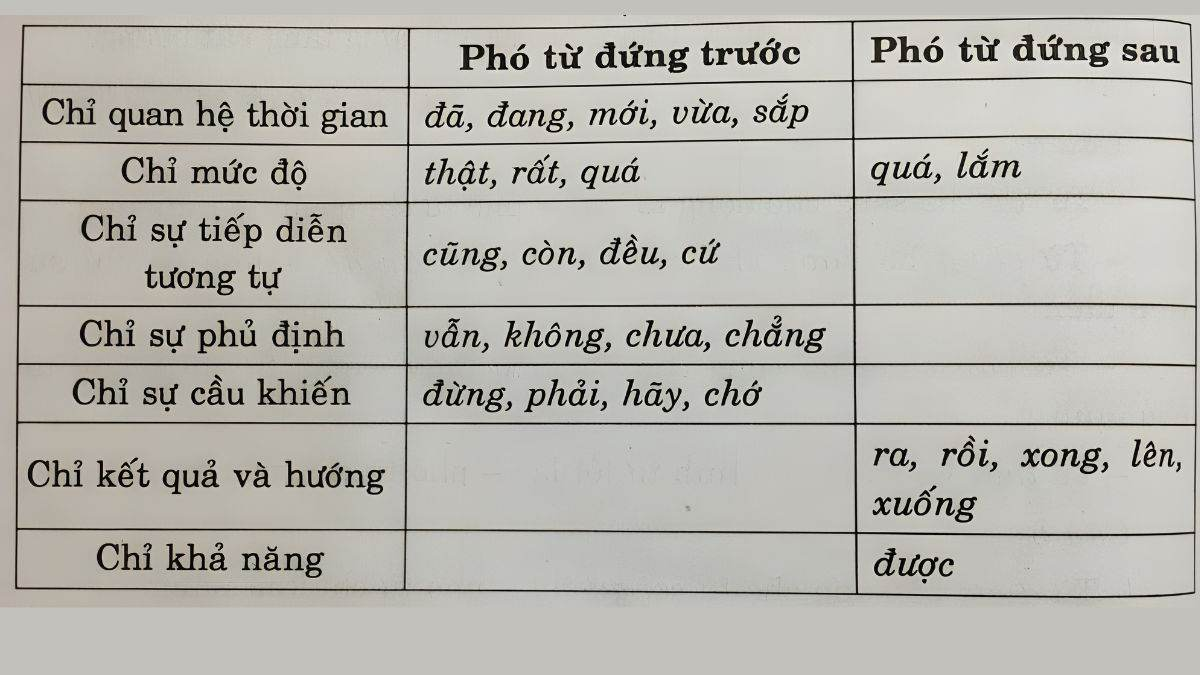

In [ ]:
def process_special_word(text):
    # có thể có nhiều từ đặc biệt cần ráp lại với nhau
    new_text = ''
    text_lst = text.split()
    i= 0
    # không, chẳng, đâu...
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

In [ ]:
data['Body_pre_fea'] = data['Body_pre_load'].apply(process_special_word)
print(data.count())
data.drop('Body_pre_load', axis=1, inplace=True)
data.head()

Body_new         976
Tag              976
Body_pre_load    976
Body_pre_fea     976
dtype: int64


,Body_new,Tag,Body_pre_fea
0,"Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên rất thân thiện. Tầm nhìn từ phòng nhìn ra biển rộng lớn và tôi đã cảm động mỗi lần nhìn. Đặc biệt là bình minh rất tuyệt vời. Vì vậy, tôi khuyên bạn nên chọn phòng với tầm nhìn ra đại dương.",Positive,tôi đã ở cùng chủ nhân đêm. nhân viên rất thân thiện. tầm nhìn từ phòng nhìn biển rộng lớn và tôi đã cảm động mỗi lần nhìn. đặc biệt là bình rất tuyệt vời. vì vậy tôi khuyên bạn nên chọn phòng với tầm nhìn đại dương.
1,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt Online được nhiều ưu đãi. Bữa sáng khá phong phú và đầy đủ dưỡng chất. Món cà ri Tôm khách sạn mời rất ngon. Sinh nhật tôi được bạn Hồng chúc mừng sinh nhật và tạo bất ngờ tại phòng.,Positive,lựa chọn mường vì giá cả phù hợp. đặt trực tuyến được nhiều ưu đãi. bữa sáng khá phú và đầy đủ dưỡng chất. món cà tôm khách sạn mời rất. nhật tôi được bạn hồng chúc mừng nhật và tạo bất ngờ tại phòng.
2,"Lần này đến với Nha Trang, tôi book phòng tại khách sạn Mường Thanh Luxury. Khách sạn trên đường Trần Phú, có view rất chill và thuận lợi để tắm biển. Nhân viên quầy lễ tân niềm nở, tận tình hướng dẫn, thủ tục nhận phòng đơn giản và nhanh chóng.",Positive,lần này đến với tôi đặt chỗ phòng tại khách sạn mường sang trọng. khách sạn trên đường trần phú có phong cảnh rất rất thư giãn và dễ chịu và thuận lợi để tắm biển. nhân viên quầy lễ tân niềm nở tận tình hướng dẫn thủ tục nhận phòng đơn giản và nhanh chóng chóng.
3,"Hôm đi đến lúc về thì mọi thứ trong Khách sạn điều tuyết vời, Nhân viên đón tiép nhiệt tình, tiện nghi đầy đủ.",Positive,hôm đi đến lúc về thì mọi thứ khách sạn điều tuyết vời nhân viên đón tiép nhiệt tình tiện đầy đủ.
4,"Khách sạn có vị trí trung tâm và sát biển. Nhân viên vui vẻ, thân thiện, mình check-in gặp bạn tiếp tân tên Lĩnh và bạn nhận hành lý tên Hiếu hỗ trợ rất nhiệt tình ! Phòng khách sạn rộng rãi , thoáng, phòng view biển quá đẹp !",Positive,khách sạn có vị trí tâm và sát biển. nhân viên vui vẻ thân thiện mình kiểm tra gặp bạn tiếp tân tên lĩnh và bạn nhận hành lý tên hiếu hỗ trợ rất nhiệt tình. phòng khách sạn rộng rãi thoáng phòng phong cảnh biển quá đẹp.


In [ ]:
def normalize_repeated_characters(text):
    # Thay thế mọi ký tự lặp liên tiếp bằng một ký tự đó
    # Ví dụ: "lònggggg" thành "lòng", "thiệtttt" thành "thiệt"
    return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
data['Body_pre_normi'] = data['Body_pre_fea'].apply(normalize_repeated_characters)
print(data.count())
data.drop('Body_pre_fea', axis=1, inplace=True)
data.head()

Body_new          976
Tag               976
Body_pre_fea      976
Body_pre_normi    976
dtype: int64


,Body_new,Tag,Body_pre_normi
0,"Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên rất thân thiện. Tầm nhìn từ phòng nhìn ra biển rộng lớn và tôi đã cảm động mỗi lần nhìn. Đặc biệt là bình minh rất tuyệt vời. Vì vậy, tôi khuyên bạn nên chọn phòng với tầm nhìn ra đại dương.",Positive,tôi đã ở cùng chủ nhân đêm. nhân viên rất thân thiện. tầm nhìn từ phòng nhìn biển rộng lớn và tôi đã cảm động mỗi lần nhìn. đặc biệt là bình rất tuyệt vời. vì vậy tôi khuyên bạn nên chọn phòng với tầm nhìn đại dương.
1,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt Online được nhiều ưu đãi. Bữa sáng khá phong phú và đầy đủ dưỡng chất. Món cà ri Tôm khách sạn mời rất ngon. Sinh nhật tôi được bạn Hồng chúc mừng sinh nhật và tạo bất ngờ tại phòng.,Positive,lựa chọn mường vì giá cả phù hợp. đặt trực tuyến được nhiều ưu đãi. bữa sáng khá phú và đầy đủ dưỡng chất. món cà tôm khách sạn mời rất. nhật tôi được bạn hồng chúc mừng nhật và tạo bất ngờ tại phòng.
2,"Lần này đến với Nha Trang, tôi book phòng tại khách sạn Mường Thanh Luxury. Khách sạn trên đường Trần Phú, có view rất chill và thuận lợi để tắm biển. Nhân viên quầy lễ tân niềm nở, tận tình hướng dẫn, thủ tục nhận phòng đơn giản và nhanh chóng.",Positive,lần này đến với tôi đặt chỗ phòng tại khách sạn mường sang trọng. khách sạn trên đường trần phú có phong cảnh rất rất thư giãn và dễ chịu và thuận lợi để tắm biển. nhân viên quầy lễ tân niềm nở tận tình hướng dẫn thủ tục nhận phòng đơn giản và nhanh chóng chóng.
3,"Hôm đi đến lúc về thì mọi thứ trong Khách sạn điều tuyết vời, Nhân viên đón tiép nhiệt tình, tiện nghi đầy đủ.",Positive,hôm đi đến lúc về thì mọi thứ khách sạn điều tuyết vời nhân viên đón tiép nhiệt tình tiện đầy đủ.
4,"Khách sạn có vị trí trung tâm và sát biển. Nhân viên vui vẻ, thân thiện, mình check-in gặp bạn tiếp tân tên Lĩnh và bạn nhận hành lý tên Hiếu hỗ trợ rất nhiệt tình ! Phòng khách sạn rộng rãi , thoáng, phòng view biển quá đẹp !",Positive,khách sạn có vị trí tâm và sát biển. nhân viên vui vẻ thân thiện mình kiểm tra gặp bạn tiếp tân tên lĩnh và bạn nhận hành lý tên hiếu hỗ trợ rất nhiệt tình. phòng khách sạn rộng rãi thoáng phòng phong cảnh biển quá đẹp.


In [ ]:
def process_postag_thesea(text):
    new_document = []
    lst_word_type = ['N', 'Np', 'A', 'AB', 'V', 'VB', 'VY', 'R']

    for sentence in sent_tokenize(text):
        tokenized_sentence = word_tokenize(sentence, format="text")  # Tokenize giữ nguyên định dạng
        words = tokenized_sentence.split()  # Tách thành danh sách từ

        # Tạo danh sách từ không có '_'
        words_to_tag = [word for word in words if "_" not in word]

        # POS tagging trên các từ không có '_'
        tagged_words = pos_tag(" ".join(words_to_tag))
        tagged_dict = {word: tag for word, tag in tagged_words}  # Dict {word: tag}

        # Xử lý từng từ trong câu
        processed_words = []
        for word in words:
            if "_" in word:
                processed_words.append(word)  # Giữ nguyên từ có '_'
            elif word in tagged_dict and tagged_dict[word] in lst_word_type:
                processed_words.append(word)  # Giữ lại từ có POS hợp lệ

        new_document.append(" ".join(processed_words))  # Ghép lại thành câu

    return " ".join(new_document)  # Trả về văn bản đã xử lý

In [ ]:
data['Body_pre_pos'] = data['Body_pre_normi'].apply(process_postag_thesea)
print(data.count())
data.drop('Body_pre_normi', axis=1, inplace=True)
data.head()

Body_new          976
Tag               976
Body_pre_normi    976
Body_pre_pos      976
dtype: int64


,Body_new,Tag,Body_pre_pos
0,"Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên rất thân thiện. Tầm nhìn từ phòng nhìn ra biển rộng lớn và tôi đã cảm động mỗi lần nhìn. Đặc biệt là bình minh rất tuyệt vời. Vì vậy, tôi khuyên bạn nên chọn phòng với tầm nhìn ra đại dương.",Positive,đã ở cùng chủ_nhân đêm nhân_viên rất thân_thiện tầm nhìn phòng nhìn biển rộng_lớn đã cảm_động lần nhìn đặc_biệt bình rất tuyệt_vời vì_vậy khuyên bạn chọn phòng tầm nhìn đại_dương
1,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt Online được nhiều ưu đãi. Bữa sáng khá phong phú và đầy đủ dưỡng chất. Món cà ri Tôm khách sạn mời rất ngon. Sinh nhật tôi được bạn Hồng chúc mừng sinh nhật và tạo bất ngờ tại phòng.,Positive,lựa_chọn mường giá_cả phù_hợp đặt trực_tuyến được nhiều ưu_đãi bữa sáng khá_phú đầy_đủ dưỡng_chất món cà_tôm khách_sạn mời rất nhật được bạn hồng_chúc mừng_nhật tạo bất_ngờ phòng
2,"Lần này đến với Nha Trang, tôi book phòng tại khách sạn Mường Thanh Luxury. Khách sạn trên đường Trần Phú, có view rất chill và thuận lợi để tắm biển. Nhân viên quầy lễ tân niềm nở, tận tình hướng dẫn, thủ tục nhận phòng đơn giản và nhanh chóng.",Positive,lần đến đặt chỗ phòng khách_sạn mường sang_trọng khách_sạn đường trần_phú có phong_cảnh rất rất thư_giãn dễ_chịu thuận_lợi tắm biển nhân_viên quầy lễ_tân niềm_nở tận_tình hướng_dẫn thủ_tục nhận phòng đơn_giản nhanh_chóng_chóng
3,"Hôm đi đến lúc về thì mọi thứ trong Khách sạn điều tuyết vời, Nhân viên đón tiép nhiệt tình, tiện nghi đầy đủ.",Positive,hôm đi lúc về khách_sạn điều_tuyết nhân_viên đón tiép nhiệt_tình_tiện đầy_đủ
4,"Khách sạn có vị trí trung tâm và sát biển. Nhân viên vui vẻ, thân thiện, mình check-in gặp bạn tiếp tân tên Lĩnh và bạn nhận hành lý tên Hiếu hỗ trợ rất nhiệt tình ! Phòng khách sạn rộng rãi , thoáng, phòng view biển quá đẹp !",Positive,khách_sạn có vị_trí_tâm sát biển nhân_viên vui_vẻ thân_thiện kiểm_tra gặp bạn tiếp_tân tên lĩnh bạn nhận hành_lý tên hiếu hỗ_trợ rất nhiệt_tình phòng khách_sạn rộng_rãi thoáng phòng phong_cảnh biển quá đẹp


In [ ]:
def remove_stopword(text, stopwords = stopwords_lst):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [ ]:
data['Body_pre_remove'] = data['Body_pre_pos'].apply(remove_stopword)
print(data.count())
data.drop('Body_pre_pos', axis=1, inplace=True)
data.head(2)

Body_new           976
Tag                976
Body_pre_pos       976
Body_pre_remove    976
dtype: int64


,Body_new,Tag,Body_pre_remove
0,"Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên rất thân thiện. Tầm nhìn từ phòng nhìn ra biển rộng lớn và tôi đã cảm động mỗi lần nhìn. Đặc biệt là bình minh rất tuyệt vời. Vì vậy, tôi khuyên bạn nên chọn phòng với tầm nhìn ra đại dương.",Positive,chủ_nhân đêm thân_thiện tầm phòng biển rộng_lớn cảm_động bình tuyệt_vời khuyên phòng tầm đại_dương
1,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt Online được nhiều ưu đãi. Bữa sáng khá phong phú và đầy đủ dưỡng chất. Món cà ri Tôm khách sạn mời rất ngon. Sinh nhật tôi được bạn Hồng chúc mừng sinh nhật và tạo bất ngờ tại phòng.,Positive,lựa_chọn mường giá_cả trực_tuyến ưu_đãi bữa khá_phú đầy_đủ dưỡng_chất món cà_tôm khách_sạn mời nhật hồng_chúc mừng_nhật phòng


In [ ]:
data.groupby('Tag').count()

,Body_new,Body_pre_remove
Tag,,
Negative,135,135
Neutral,152,152
Positive,689,689


In [ ]:
# Tách dữ liệu theo từng loại tag
df_negative = data[data['Tag'] == 'Negative']
df_neutral = data[data['Tag'] == 'Neutral']
df_positive = data[data['Tag'] == 'Positive']

# Chọn ngẫu nhiên 389 dòng từ Positive
df_positive_sample = df_positive.sample(n=389, random_state=42)

# Gộp lại thành dataset mới
df_new = pd.concat([df_negative, df_neutral, df_positive_sample])

# Reset index
final_data = df_new.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
file = open('/content/gdrive/MyDrive/Sentiment-Analysis/files/positive_words.txt', 'r', encoding="utf8")
positive_words = file.read().split('\n')
file.close()

file = open('/content/gdrive/MyDrive/Sentiment-Analysis/files/negative_words.txt', 'r', encoding="utf8")
negative_words = file.read().split('\n')
file.close()

def find_posi_words(document):
    word_list = []

    for word in positive_words:
        if word in document:
            word_list.append(word)

    return word_list

def find_nega_words(document):
    word_list = []
    words = document.split()  # Tách câu thành danh sách từ

    for word in negative_words:
        if word in words:  # Kiểm tra từ có tồn tại trong danh sách không
            word_list.append(word)

    return word_list

In [ ]:
final_data['positive_words'] = final_data['Body_pre_remove'].apply(find_posi_words)
final_data['negative_words'] = final_data['Body_pre_remove'].apply(find_nega_words)

final_data['positive_count'] = final_data['positive_words'].apply(len)
final_data['negative_count'] = final_data['negative_words'].apply(len)

final_data.head(2)

,Body_new,Tag,Body_pre_remove,positive_words,negative_words,positive_count,negative_count
0,Vị trí rất tốt Phòng sạch rộng và yên tĩnh Giá thuê so với chất lượng rất tốt,Positive,tốt phòng sạch rộng yên_tĩnh giá thuê chất_lượng tốt,"[tốt, chất_lượng, sạch, yên_tĩnh]",[],4,0
1,"Khách sạn mới, sạch sẽ, vị trí thuận tiện cách biển 3p đi bộ. Nhân viên nhiệt tình, chuyên nghiệp. Sẽ quay lại lần sau.",Positive,khách_sạn sạch_sẽ thuận_tiện biển đi nhiệt_tình chuyên_nghiệp,"[sạch_sẽ, sạch, thuận_tiện, chuyên_nghiệp]",[],4,0


In [ ]:
final_data.to_csv("final_data.csv", index=False, encoding="utf-8-sig")

In [ ]:
final_data.groupby('Tag').count()

,Body_new,Body_pre_remove,positive_words,negative_words,positive_count,negative_count
Tag,,,,,,
Negative,135,135,135,135,135,135
Neutral,152,152,152,152,152,152
Positive,389,389,389,389,389,389


In [ ]:
final_data.head(5)

,Body_new,Tag,Body_pre_remove,positive_words,negative_words,positive_count,negative_count
0,Vị trí rất tốt Phòng sạch rộng và yên tĩnh Giá thuê so với chất lượng rất tốt,Positive,tốt phòng sạch rộng yên_tĩnh giá thuê chất_lượng tốt,"[tốt, chất_lượng, sạch, yên_tĩnh]",[],4,0
1,"Khách sạn mới, sạch sẽ, vị trí thuận tiện cách biển 3p đi bộ. Nhân viên nhiệt tình, chuyên nghiệp. Sẽ quay lại lần sau.",Positive,khách_sạn sạch_sẽ thuận_tiện biển đi nhiệt_tình chuyên_nghiệp,"[sạch_sẽ, sạch, thuận_tiện, chuyên_nghiệp]",[],4,0
2,"Ks ở trong hẻm cách đường lớn khoảng 15 20m. Gần quảng trường, chợ đêm. Ra biển khoảng 300m đi bộ. Ổn so với mức giá. Phòng có đặc điểm là đèn vàng, khi cần ánh sáng cảm thấy rất thiếu thốn. Khắc phục cái này nữa là ok. Lễ tân 24/24",Positive,khách_sạn hẻm đường quảng_trường chợ đêm biển đi ổn giá phòng đặc_điểm đèn vàng ánh_sáng thiếu_thốn khắc_phục đồng_ý,"[ổn, đồng_ý]",[thiếu_thốn],2,1
3,"Căn hộ sạch sẽ, tiện nghi, view đẹp ngay trung tâm thành phố, nơi ở thuận tiện đề di chuyển giữa các nơi trong nha trang. Đi công tác hay đi du lịch ở tại đây cảm giác thoải mái như ở nhà.",Positive,căn_hộ sạch_sẽ tiện phong_cảnh đẹp_tâm thành_phố thuận_tiện đề di_chuyển đi công_tác cỏ khô đi lịch cảm_giác thoải_mái,"[đẹp, sạch_sẽ, sạch, thoải_mái, thuận_tiện]",[],5,0
4,"Cho checkin sớm, check out late 2 tiếng không tính tiền, phòng giá rẻ , nhưng sạch sẽ ở ok. Sẽ quay lại",Positive,đăng_ký kiểm_tra muộn tiếng tiền phòng giá rẻ sạch_sẽ đồng_ý,"[rẻ, sạch_sẽ, sạch, đồng_ý]",[],4,0


In [ ]:
final_data.to_csv('final_data', index=False, encoding="utf-8-sig")

<ipython-input-96-325fb82378b0>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=positive_words_df, palette='viridis')


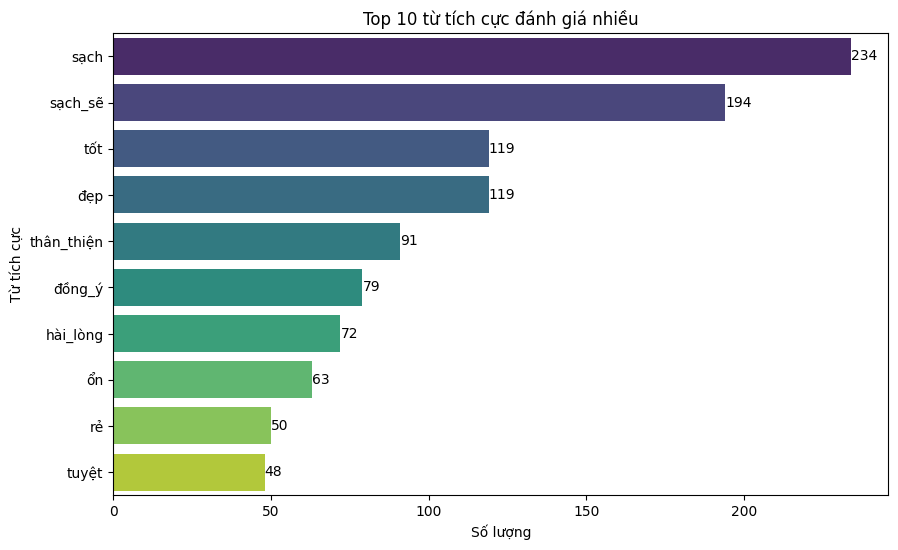

In [ ]:
final_data['positive_words_str'] = final_data['positive_words'].apply(lambda x: ','.join(x))

# Gom tất cả các chuỗi lại thành một chuỗi văn bản lớn duy nhất
positive_words_str = final_data['positive_words_str'].tolist()

#Loại bỏ các ''
filtered_data = list(filter(None, positive_words_str))

#Tách cụm thành các từ riêng lẻ
separated_words = []
for phrase in filtered_data:
    separated_words.extend(phrase.split(','))

# Loại bỏ khoảng trắng thừa và kết hợp lại thành một chuỗi
cleaned_words = [word.strip() for word in separated_words]

#Đếm số lượng từ xuất hiện
word_counts = Counter(cleaned_words)

# Lấy 10 từ xuất hiện nhiều nhất
common_words = word_counts.most_common(10)

# Tạo DataFrame để vẽ biểu đồ
positive_words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Word', data=positive_words_df, palette='viridis')
# Thêm số lượng trên đỉnh mỗi cột
for index, value in enumerate(positive_words_df['Count']):
    plt.text(value, index, str(value), color='black', ha="left", va="center")
plt.title('Top 10 từ tích cực đánh giá nhiều')
plt.xlabel('Số lượng')
plt.ylabel('Từ tích cực')
plt.show()

<ipython-input-97-281d08935b36>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=negative_words_str, palette='viridis')


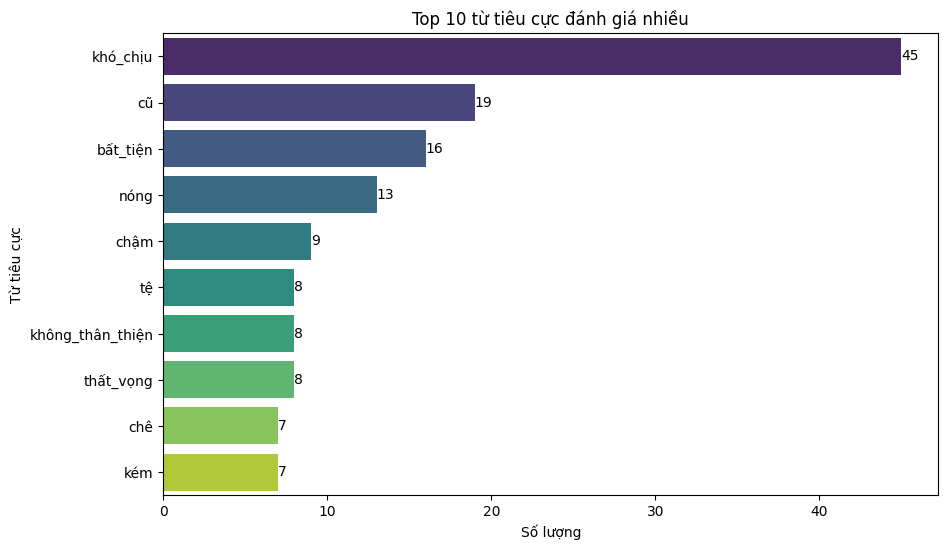

In [ ]:
final_data['negative_words_str'] = final_data['negative_words'].apply(lambda x: ','.join(x))

# Gom tất cả các chuỗi lại thành một chuỗi văn bản lớn duy nhất
negative_words_str = final_data['negative_words_str'].tolist()

#Loại bỏ các ''
filtered_data = list(filter(None, negative_words_str))

#Tách cụm thành các từ riêng lẻ
separated_words = []
for phrase in filtered_data:
    separated_words.extend(phrase.split(','))

# Loại bỏ khoảng trắng thừa và kết hợp lại thành một chuỗi
cleaned_words = [word.strip() for word in separated_words]

#Đếm số lượng từ xuất hiện
word_counts = Counter(cleaned_words)

# Lấy 10 từ xuất hiện nhiều nhất
common_words = word_counts.most_common(10)

# Tạo DataFrame để vẽ biểu đồ
negative_words_str = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Word', data=negative_words_str, palette='viridis')
# Thêm số lượng trên đỉnh mỗi cột
for index, value in enumerate(negative_words_str['Count']):
    plt.text(value, index, str(value), color='black', ha="left", va="center")
plt.title('Top 10 từ tiêu cực đánh giá nhiều')
plt.xlabel('Số lượng')
plt.ylabel('Từ tiêu cực')
plt.show()

##TRAINING, PREDICT

In [ ]:
final_data = final_data.drop(['negative_words_str', 'positive_words_str'], axis=1)

In [ ]:
# Tạo vectorizer
vectorizer = TfidfVectorizer()

# Khởi tạo mô hình
detree = DecisionTreeClassifier()

# Cross-Validation với 5 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
times = []

for fold, (train_idx, test_idx) in enumerate(skf.split(final_data['Body_pre_remove'], final_data['Tag'])):
    print(f"Fold {fold+1}:")

    # Lấy dữ liệu train/test
    X_train, X_test = final_data['Body_pre_remove'].iloc[train_idx], final_data['Body_pre_remove'].iloc[test_idx]
    y_train, y_test = final_data['Tag'].iloc[train_idx], final_data['Tag'].iloc[test_idx]

    # TF-IDF Vectorization
    train_X = vectorizer.fit_transform(X_train)
    test_X = vectorizer.transform(X_test)

    # Train model
    start_time = time.time()
    detree_model = detree.fit(train_X, y_train)
    end_time = time.time()

    # Dự đoán
    y_pred_detree = detree_model.predict(test_X)

    # Đánh giá
    acc = accuracy_score(y_test, y_pred_detree)
    accuracies.append(acc)
    times.append(end_time - start_time)

    print(f"  Accuracy: {acc:.4f}")
    print(f"  Training Time: {end_time - start_time:.2f} seconds")

Fold 1:
  Accuracy: 0.6912
  Training Time: 0.04 seconds
Fold 2:
  Accuracy: 0.6176
  Training Time: 0.04 seconds
Fold 3:
  Accuracy: 0.6176
  Training Time: 0.03 seconds
Fold 4:
  Accuracy: 0.6029
  Training Time: 0.04 seconds
Fold 5:
  Accuracy: 0.6324
  Training Time: 0.04 seconds
Fold 6:
  Accuracy: 0.5588
  Training Time: 0.03 seconds
Fold 7:
  Accuracy: 0.5672
  Training Time: 0.03 seconds
Fold 8:
  Accuracy: 0.5522
  Training Time: 0.04 seconds
Fold 9:
  Accuracy: 0.6269
  Training Time: 0.04 seconds
Fold 10:
  Accuracy: 0.6866
  Training Time: 0.04 seconds
